# Discovery of Non-Linear Pendulum Dynamics using SODAs: Simulation vs Data

This notebook estimates the parameters of the pendulum model that is discovered using SODAs using spipy's curve fit function and plot  the solution of discovered ODE against the video footage data.

In [3]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


## Loading data

In [33]:

# Loading pendulum data
df_list = []
index_list = [4,8,9]
for ind in index_list:
    file_path = f"data/pendulum_recording_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

trimming_slices=  [(100,500), (100,500), (100,500), (100,500), (50,500)] #for finding the dynamic equation


# trimming_slices=  [(50,300), (50,300), (50,300), (100,400), (50,400)]


df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center_dict = {4:((1578+1589)/2, (56+319)/2), 6:  ((903+906)/2, (45+150)/2)}
center_dict[7] = ((1126+1122)/2, (2+128)/2)
center_dict[8] = ((993+990)/2, (44+165)/2)
center_dict[9] = ((993+990)/2, (44+165)/2)
center_dict[10] = ((962+965)/2, (44+176)/2)
# center = ((1578+1589)/2, (56+319)/2) # 4
# center = ((903+906)/2, (45+150)/2) #6
color = [120, 255, 243]
for ind, df_ in zip(index_list, df_trimmed):
    df_["x"] = df_["X"] - center_dict[ind][0]
    df_["y"] = -(df_["Y"] - center_dict[ind][1])

# for i, df in enumerate(df_trimmed):
#     df.to_csv(f"data/trimmed_pendulum_time_series_damped_{i+1}.csv", index=False)

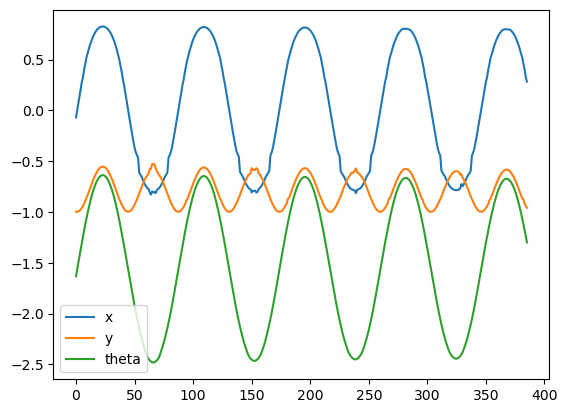

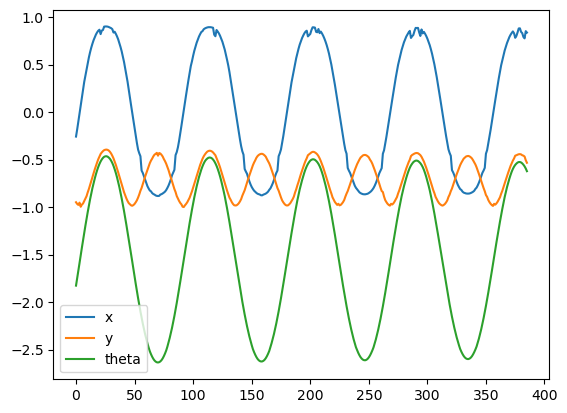

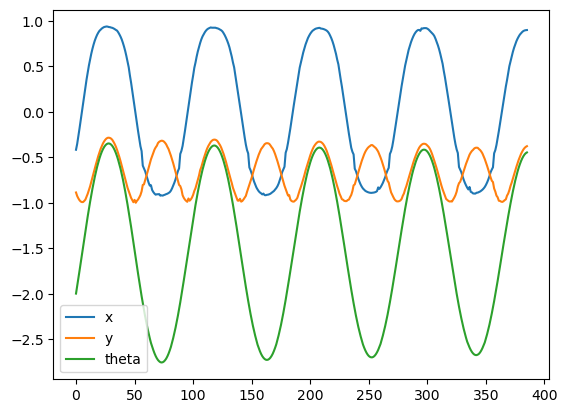

In [34]:
L=1    
smoothening_window_size = 15
#Scaling the pendulum length to L
for df_ in df_trimmed:

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    pen_orig_len = abs(df_["y"]).max()
    df_["x"] = (df_["x"]/pen_orig_len) * L
    df_["y"] = (df_["y"]/pen_orig_len) * L

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    df_.dropna(ignore_index=True, inplace=True)

df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:
    df_[["x", "y", "theta"]].plot()


In [35]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[20:-150] #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt"]]


data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

## Fomring the candidate library

In [7]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 3
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))

#Adding sin and cos terms using x and y
candidate_lib_full["cos(theta)"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["sin(theta)"] = data_matrix_df_smooth_appended["y"]

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['theta', 'theta_dot', 'theta^2', 'theta theta_dot', 'theta_dot^2',
       'theta^3', 'theta^2 theta_dot', 'theta theta_dot^2', 'theta_dot^3'],
      dtype='object')


In [8]:
# candidate_lib_full["sin(theta)"] = np.sin(candidate_lib_full["theta"])
# candidate_lib_full["cos(theta)"] = np.cos(candidate_lib_full["theta"])


# candidate_lib_full["x"] = df_trimmed[0][100:-100]["x"].reset_index(drop=True)
# candidate_lib_full["y"] = df_trimmed[0][100:-100]["y"].reset_index(drop=True)


## Parameter estimation

In [10]:

df_new_0 = df_trimmed[0][(df_trimmed[0]['x'].diff().abs() < 0.1) & (df_trimmed[0]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_0 = df_new_0[19:]
omega0_0 = data_matrix_smooth_df_list[0]["d(theta) /dt"].iloc[0]

df_new_1 = df_trimmed[1][(df_trimmed[1]['x'].diff().abs() < 0.1) & (df_trimmed[1]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_1 = df_new_1[19:]
omega0_1 = data_matrix_smooth_df_list[1]["d(theta) /dt"].iloc[0]


df_new_2 = df_trimmed[2][(df_trimmed[2]['x'].diff().abs() < 0.1) & (df_trimmed[2]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_2 = df_new_2[19:]
omega0_2 = data_matrix_smooth_df_list[2]["d(theta) /dt"].iloc[0]


In [11]:
omega0_0, omega0_1, omega0_2

(1.5270948229951304, 3.313872091695751, 4.839572217284557)

In [13]:
from scipy.optimize import curve_fit



# Define the pendulum ODE function
def pendulum_rhs(t, y, beta, gamma, L=1):
    theta, omega = y
    alpha = beta * np.cos(theta) + gamma * theta
    return [omega, alpha]

# Define the pendulum ODE function for curve fitting
def pendulum_ode_combined(t, beta, gamma):
    # Initial conditions for each dataset
    initial_conditions = [
        (df_new_0['theta'].iloc[0], omega0_0),
        (df_new_1['theta'].iloc[0], omega0_1),
        (df_new_2['theta'].iloc[0], omega0_2)
    ]
    
    # Time values for each dataset
    t_values_list = [df_new_0['t'].values, df_new_1['t'].values, df_new_2['t'].values]
    
    # Solve the ODE for each dataset and concatenate the results
    theta_values_combined = []
    for (theta0, omega0), t_values in zip(initial_conditions, t_values_list):
        y0 = [theta0, omega0]
        sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta, gamma))
        theta_values_combined.extend(sol.y[0])
    
    return np.array(theta_values_combined)

# Combine the theta values from all datasets
theta_values_combined = np.concatenate([df_new_0['theta'].values, df_new_1['theta'].values, df_new_2['theta'].values])

# Combine the time values from all datasets
t_values_combined = np.concatenate([df_new_0['t'].values, df_new_1['t'].values, df_new_2['t'].values])

# Define initial guesses for beta and gamma
initial_guesses = [
    [-6.5, -3],
    [-10, -5],
    [-5, -2],
    [-8, -4],
    [-10, -10],
    [-5, 0],
    [0, -5],
    [5, 5],
    [10, 10],
    [15, -15],
    [-20, 20],
    [25, -25],
    [-30, 30],
    [-100,0],
    [0,-100]
]

best_params = None
best_rss = np.inf

# Perform curve fitting with different initial guesses
for initial_guess in initial_guesses:
    params, params_covariance = curve_fit(pendulum_ode_combined, t_values_combined, theta_values_combined, p0=initial_guess, maxfev=1000)
    beta_est, gamma_est = params
    
    # Calculate the residual sum of squares (RSS)
    theta_fitted = pendulum_ode_combined(t_values_combined, beta_est, gamma_est)
    rss = np.sum((theta_values_combined - theta_fitted) ** 2)
    
    # Update the best parameters if the current RSS is lower
    if rss < best_rss:
        best_rss = rss
        best_params = params

beta_est, gamma_est = best_params
print(f"Best estimated beta: {beta_est}")
print(f"Best estimated gamma: {gamma_est}")
print(f"Best RSS: {best_rss}")

Best estimated beta: -82.9811497389859
Best estimated gamma: -0.7967016088688774
Best RSS: 0.5612958619319421


In [419]:
# from scipy.integrate import solve_ivp
# import matplotlib.pyplot as plt

# # Define the pendulum ODE function using the optimized parameters
# def pendulum_rhs(t, y, beta, gamma, L=1):
#     theta, omega = y
#     alpha = beta * np.cos(theta) + gamma * theta
#     return [omega, alpha]

# # Function to plot actual vs simulated theta for a given dataset
# def plot_actual_vs_simulated(df_new, omega0, beta_est, gamma_est, title):
#     t_values = df_new['t'].values
#     theta_values = df_new['theta'].values

#     # Initial conditions: theta(0) and omega(0)
#     theta0 = theta_values[0]
#     y0 = [theta0, omega0]

#     # Solve the ODE using the optimized parameters
#     sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta_est, gamma_est))

#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(t_values, theta_values, label='Actual Theta', color='blue')
#     plt.plot(t_values, sol.y[0], label='Simulated Theta', color='red', linestyle='--')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Theta (radians)')
#     plt.title(title)
#     plt.legend()
#     plt.show()

# # Plot for df_new_0
# plot_actual_vs_simulated(df_new_0, omega0_0, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_0')

# # Plot for df_new_1
# plot_actual_vs_simulated(df_new_1, omega0_1, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_1')

# # Plot for df_new_2
# plot_actual_vs_simulated(df_new_2, omega0_2, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_2')

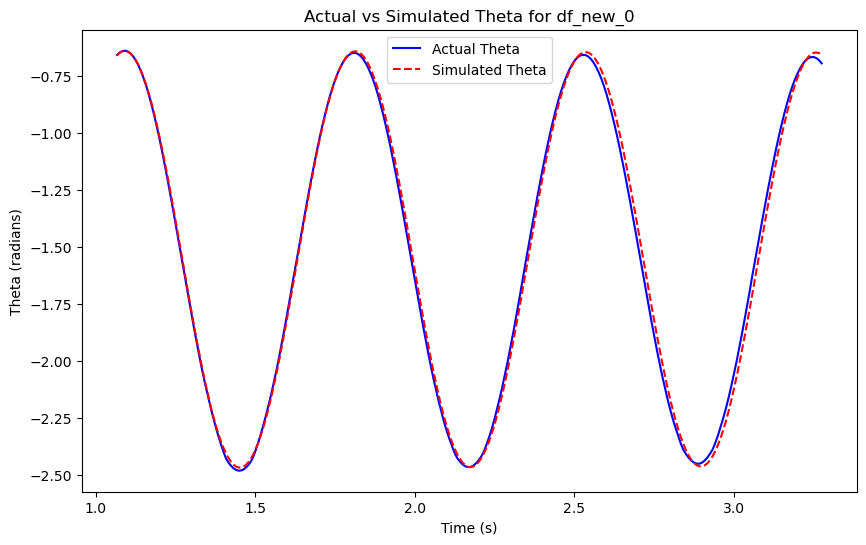

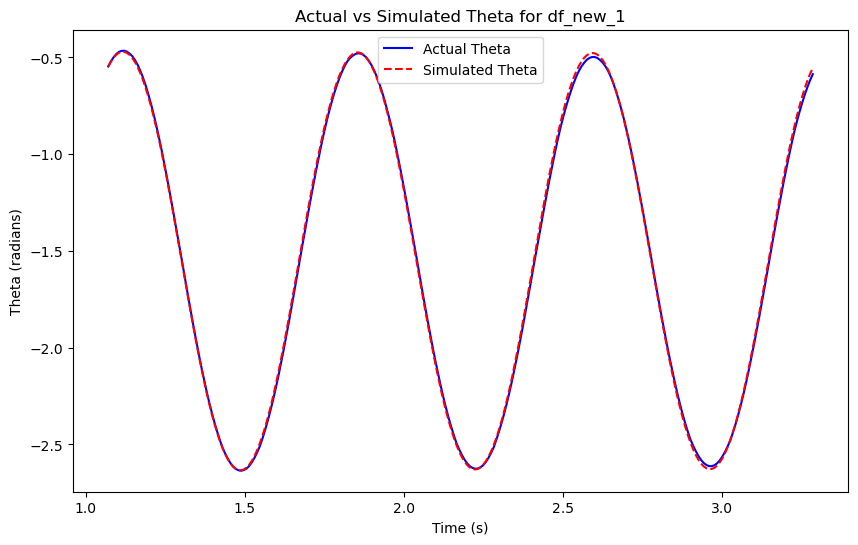

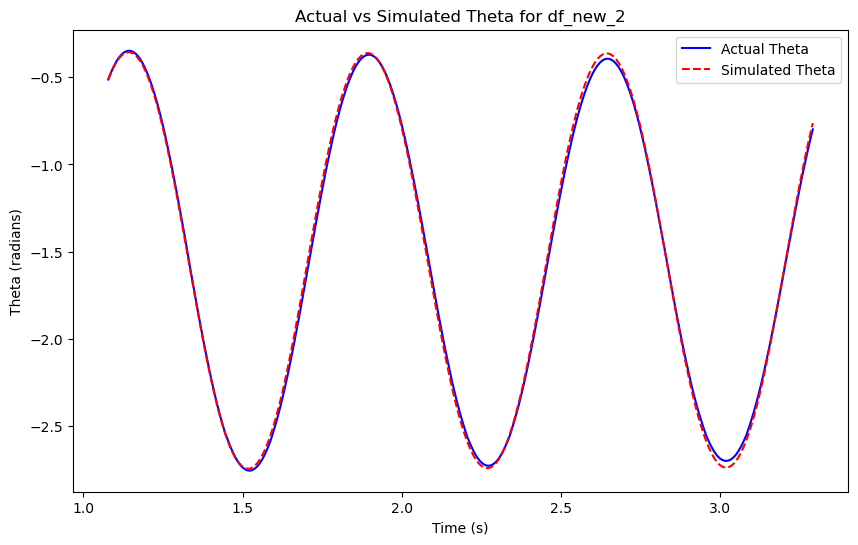

In [14]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the pendulum ODE function using the optimized parameters
def pendulum_rhs(t, y, beta, gamma, L=1):
    theta, omega = y
    alpha = beta * np.cos(theta) + gamma * theta
    return [omega, alpha]

# Function to plot actual vs simulated theta for a given dataset
def plot_actual_vs_simulated(df_new, omega0, beta_est, gamma_est, title):
    t_values = df_new['t'].values
    theta_values = df_new['theta'].values

    # Initial conditions: theta(0) and omega(0)
    theta0 = theta_values[0]
    y0 = [theta0, omega0]

    # Solve the ODE using the optimized parameters
    sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta_est, gamma_est))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, theta_values, label='Actual Theta', color='blue')
    plt.plot(t_values, sol.y[0], label='Simulated Theta', color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Theta (radians)')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot for df_new_0
plot_actual_vs_simulated(df_new_0, omega0_0, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_0')

# Plot for df_new_1
plot_actual_vs_simulated(df_new_1, omega0_1, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_1')

# Plot for df_new_2
plot_actual_vs_simulated(df_new_2, omega0_2, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_2')

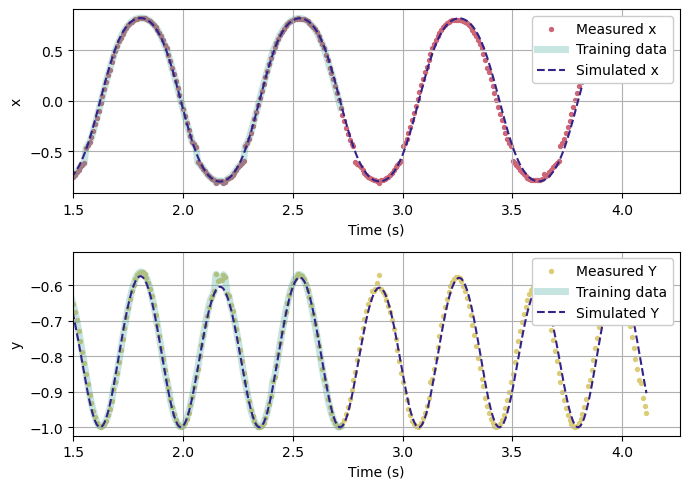

In [99]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def pendulum_rhs(t, y, beta, gamma, L=1):
    theta, omega = y
    alpha = beta * np.cos(theta) + gamma * theta
    return [omega, alpha]
def plot_actual_vs_simulated(df_new, omega0, beta_est, gamma_est, title, training_num=200):
    t_values = df_new['t'].values
    x_values = df_new['x'].values
    y_values = df_new['y'].values

    theta0 = np.arctan2(y_values[0], x_values[0])
    y0 = [theta0, omega0]

    sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta_est, gamma_est))

    theta_simulated = sol.y[0]
    x_simulated = L * np.cos(theta_simulated)
    y_simulated = L * np.sin(theta_simulated)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

    ax1.scatter(t_values, x_values, label='Measured x', color='#CC6677', s=8)
    ax1.plot(t_values[:training_num], x_values[:training_num], label='Training data', color='#44AA99', linewidth=5, alpha=0.3)
    ax1.plot(t_values, x_simulated, label='Simulated x', color='#332288', linestyle='--')
    ax1.grid(True)
    ax1.set_xlim(left=1.5)

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('x')
    legend1 = ax1.legend(loc='upper right')
    legend1.get_frame().set_facecolor('white')
    legend1.get_frame().set_alpha(1)

    ax2.scatter(t_values, y_values, label='Measured Y', color='#DDCC77', s=8)
    ax2.plot(t_values[:training_num], y_values[:training_num], label='Training data', color='#44AA99', linewidth=5, alpha=0.3)
    ax2.plot(t_values, y_simulated, label='Simulated Y', color='#332288', linestyle='--')
    ax2.grid(True)
    ax2.set_xlim(left=1.5)

    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('y')
    legend2 = ax2.legend(loc='upper right')
    legend2.get_frame().set_facecolor('white')
    legend2.get_frame().set_alpha(1)

    plt.tight_layout()
    plt.show()
    fig.savefig('Example_2_pendulum_experiment_prediction.svg', format='svg')
plot_actual_vs_simulated(df_trimmed[0][19:], omega0_0, beta_est, gamma_est, 'Actual vs Simulated for df_new_0')

# # Plot for df_new_1
# plot_actual_vs_simulated(df_trimmed[1][19:], omega0_1, beta_est, gamma_est, 'Actual vs Simulated for df_new_1')

# # Plot for df_new_2
# plot_actual_vs_simulated(df_trimmed[2][19:], omega0_2, beta_est, gamma_est, 'Actual vs Simulated for df_new_2')


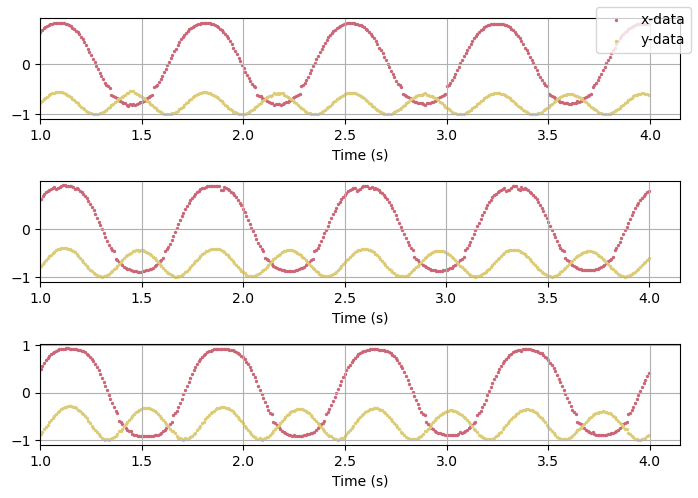

In [98]:
fig, axes = plt.subplots(len(df_trimmed), 1, figsize=(7, 5))

for i, df in enumerate(df_trimmed):
    df_subset = df[(df['t'] >= 0.2) & (df['t'] <= 4)]
    
    axes[i].scatter(df_subset['t'], df_subset['x'], label='x-data', s=2, color='#CC6677')
    axes[i].scatter(df_subset['t'], df_subset['y'], label='y-data', s=2, color='#DDCC77')
    axes[i].set_xlabel('Time (s)')
    axes[i].grid(True)  # Add grid
    axes[i].set_xlim(left=1)  # Set x limit to start from 1

# Create a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()
